In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
ner_test_data = json.load(open('NER_test.json', 'r'))
ate_test_data = json.load(open('ATE_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

# VANILLA RNN

In [2]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# GRU Implementation

In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# BiLSTM-CRF Implementation

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(2*hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2) # (len, 1, num_tags) to (1, len, num_tags)
        out = out.to(device=x.device)
        return out

In [22]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

def clean_word(word):
    import string
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    clean_word = clean_word.strip()
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TASK-1 NER Dataset

In [25]:

def test_ner(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(1)
            labelwise_predictions[test_actual[i]]["predicted"].append(1 if test_actual[i] == test_predicted[i] else 0)
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [26]:
def test_ner_crf(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False, print_labelwise=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.squeeze(0).tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            label = label[2:] if label != 'O' else label
            labelwise_predictions[label] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            actual_bio_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_actual[i])]
            actual_label = actual_bio_label[2:] if actual_bio_label != 'O' else actual_bio_label
            predicted_bio_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_predicted[i])]
            predicted_label = predicted_bio_label[2:] if predicted_bio_label != 'O' else predicted_bio_label
            labelwise_predictions[actual_label]["actual"].append(1)
            labelwise_predictions[actual_label]["predicted"].append(1 if actual_label == predicted_label else 0)
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        if print_labelwise:
            print('Labelwise F1 Scores:')
            print(labelwise_f1)
            print('Labelwise Accuracy Scores:')
            print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
            plt.bar(labelwise_accuracy.keys(), labelwise_accuracy.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('Accuracy')
            plt.show()
    return accuracy, f1

### VANILLA RNN 

In [27]:
test_accuracy, test_f1 = test_ner("t1_model1_word2vec.pt", word2vec, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model1_glove.pt", glove, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model1_fasttext.pt", fasttext, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with Word2Vec ==> Accuracy: 0.9226, F1: 0.5512
Vaniila RNN with GloVe ==> Accuracy: 0.8571, F1: 0.2393
Vaniila RNN with FastText ==> Accuracy: 0.9254, F1: 0.5079


### LSTM

In [28]:
test_accuracy, test_f1 = test_ner("t1_model2_word2vec.pt", word2vec, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model2_glove.pt", glove, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model2_fasttext.pt", fasttext, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

LSTM with Word2Vec ==> Accuracy: 0.9303, F1: 0.5994
LSTM with GloVe ==> Accuracy: 0.8956, F1: 0.3976
LSTM with FastText ==> Accuracy: 0.9314, F1: 0.5237


### GRU

In [29]:
test_accuracy, test_f1 = test_ner("t1_model3_word2vec.pt", word2vec, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model3_glove.pt", glove, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner("t1_model3_fasttext.pt", fasttext, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with Word2Vec ==> Accuracy: 0.9280, F1: 0.5808
GRU with GloVe ==> Accuracy: 0.8939, F1: 0.4068
GRU with FastText ==> Accuracy: 0.9361, F1: 0.6122


### BiLSTM CRF

In [30]:
test_accuracy, test_f1 = test_ner_crf("t1_model4_word2vec.pt", word2vec, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner_crf("t1_model4_glove.pt", glove, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ner_crf("t1_model4_fasttext.pt", fasttext, ner_test_data, device=device, show_labelwise=False, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9521, F1: 0.6967
Bi-LSTM CRF with GloVe ==> Accuracy: 0.9097, F1: 0.4396
Bi-LSTM CRF with FastText ==> Accuracy: 0.9546, F1: 0.7063


Bi-LSTM CRF with Word2Vec: Labelwise plots


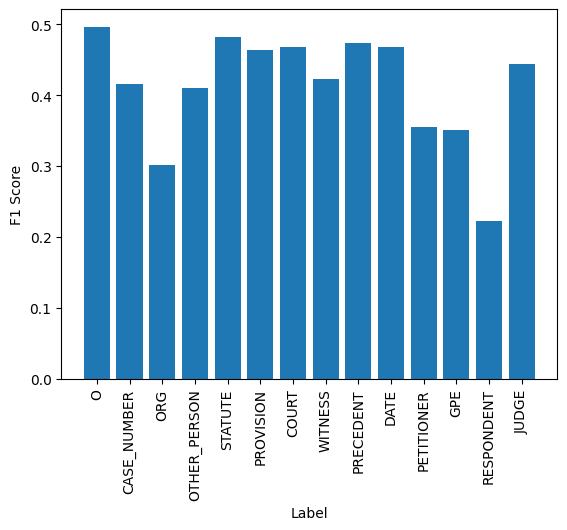

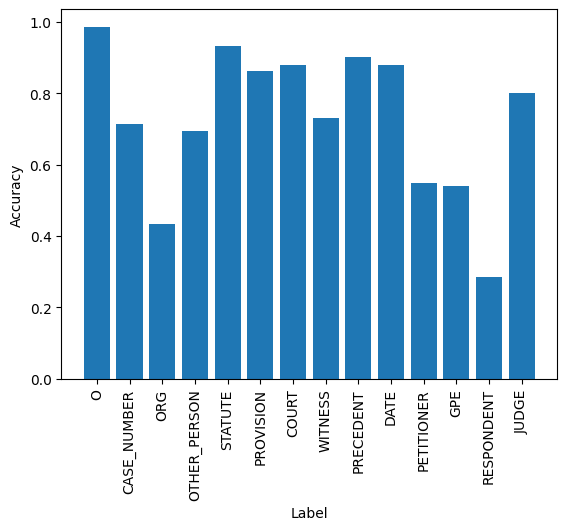

Bi-LSTM CRF with GloVe: Labelwise plots


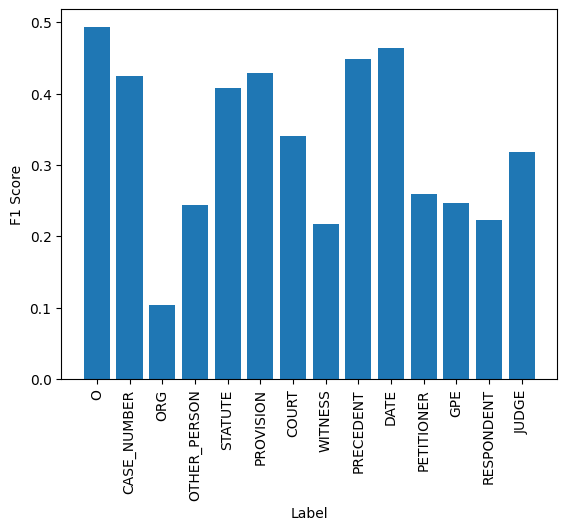

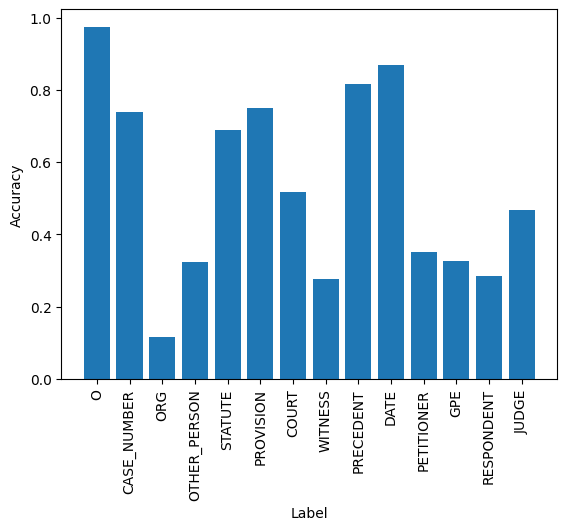

Bi-LSTM CRF with FastText: Labelwise plots


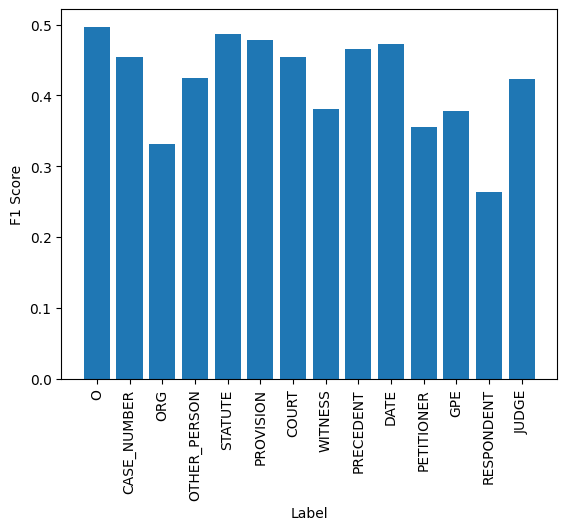

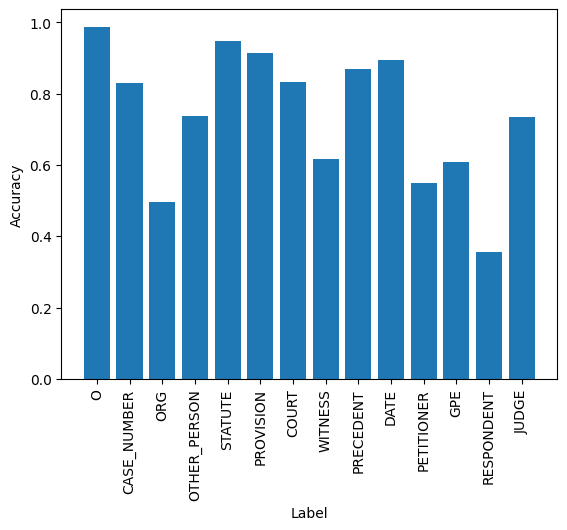

In [31]:
print('Bi-LSTM CRF with Word2Vec: Labelwise plots')
test_accuracy, test_f1 = test_ner_crf("t1_model4_word2vec.pt", word2vec, ner_test_data, device=device, show_labelwise=True, plot=True)

print('Bi-LSTM CRF with GloVe: Labelwise plots')
test_accuracy, test_f1 = test_ner_crf("t1_model4_glove.pt", glove, ner_test_data, device=device, show_labelwise=True, plot=True)

print('Bi-LSTM CRF with FastText: Labelwise plots')
test_accuracy, test_f1 = test_ner_crf("t1_model4_fasttext.pt", fasttext, ner_test_data, device=device, show_labelwise=True, plot=True)

# TASK-2 ATE Dataset

In [32]:
def test_ate(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(1)
            labelwise_predictions[test_actual[i]]["predicted"].append(1 if test_actual[i] == test_predicted[i] else 0)
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [33]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False, print_labelwise=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            targets = targets.squeeze(0)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            actual_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_actual[i])]
            predicted_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_predicted[i])]
            labelwise_predictions[actual_label]["actual"].append(1)
            labelwise_predictions[actual_label]["predicted"].append(1 if actual_label == predicted_label else 0)
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        if print_labelwise:
            print('Labelwise F1 Scores:')
            print(labelwise_f1)
            print('Labelwise Accuracy Scores:')
            print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
            plt.bar(labelwise_accuracy.keys(), labelwise_accuracy.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('Accuracy')
            plt.show()
    return accuracy, f1

### Vanilla RNN

In [34]:
test_accuracy, test_f1 = test_ate("t2_model1_word2vec.pt", word2vec, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model1_glove.pt", glove, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model1_fasttext.pt", fasttext, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with Word2Vec ==> Accuracy: 0.9230, F1: 0.7554
Vaniila RNN with GloVe ==> Accuracy: 0.9047, F1: 0.6797
Vaniila RNN with FastText ==> Accuracy: 0.9213, F1: 0.7312


### LSTM

In [35]:
test_accuracy, test_f1 = test_ate("t2_model2_word2vec.pt", word2vec, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model2_glove.pt", glove, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model2_fasttext.pt", fasttext, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

LSTM with Word2Vec ==> Accuracy: 0.9277, F1: 0.7758
LSTM with GloVe ==> Accuracy: 0.9149, F1: 0.7022


LSTM with FastText ==> Accuracy: 0.9248, F1: 0.7636


### GRU

In [36]:
test_accuracy, test_f1 = test_ate("t2_model3_word2vec.pt", word2vec, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model3_glove.pt", glove, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test_ate("t2_model3_fasttext.pt", fasttext, ate_test_data, device=device, show_labelwise=False, plot=True)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with Word2Vec ==> Accuracy: 0.9257, F1: 0.7651
GRU with GloVe ==> Accuracy: 0.9145, F1: 0.7196
GRU with FastText ==> Accuracy: 0.9298, F1: 0.7718


### BiLSTM CRF

In [37]:
test_accuracy, test_f1 = test("t2_model4_word2vec.pt", word2vec, ate_test_data, device=device, show_labelwise=False, plot=True, print_labelwise=False)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test("t2_model4_glove.pt", glove, ate_test_data, device=device, show_labelwise=False, plot=True, print_labelwise=False)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

test_accuracy, test_f1 = test("t2_model4_fasttext.pt", fasttext, ate_test_data, device=device, show_labelwise=False, plot=True, print_labelwise=False)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9358, F1: 0.8007
Bi-LSTM CRF with GloVe ==> Accuracy: 0.9226, F1: 0.7418
Bi-LSTM CRF with FastText ==> Accuracy: 0.9356, F1: 0.7884


Bi-LSTM CRF with Word2Vec: Labelwise plots


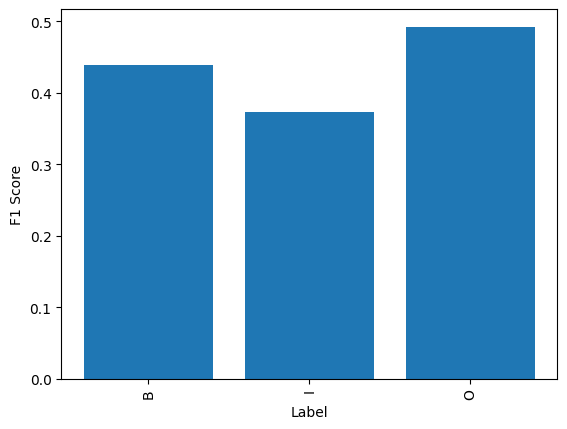

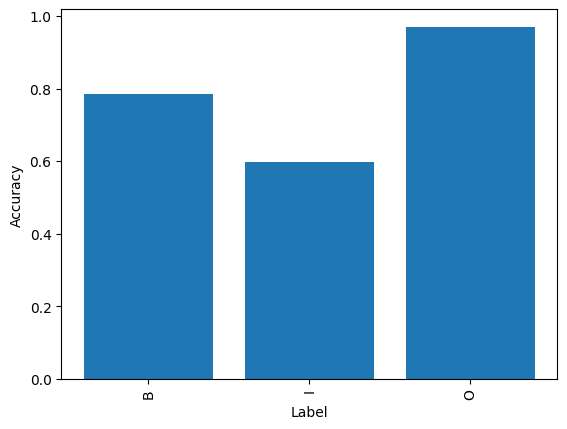

Bi-LSTM CRF with GloVe: Labelwise plots


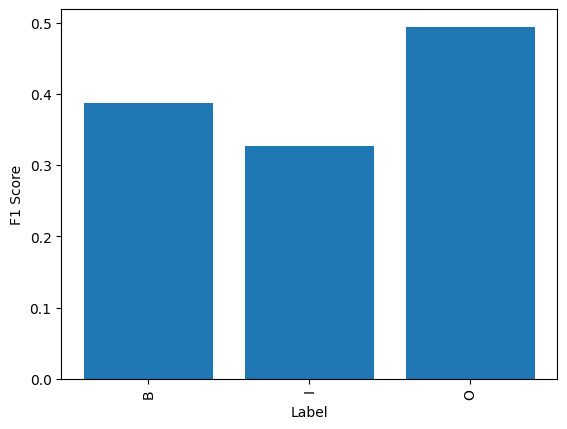

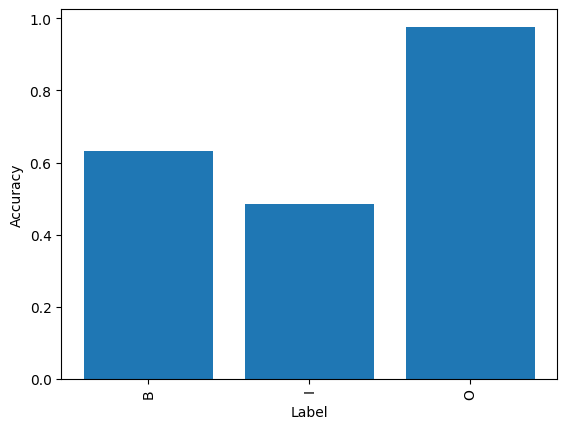

Bi-LSTM CRF with FastText: Labelwise plots


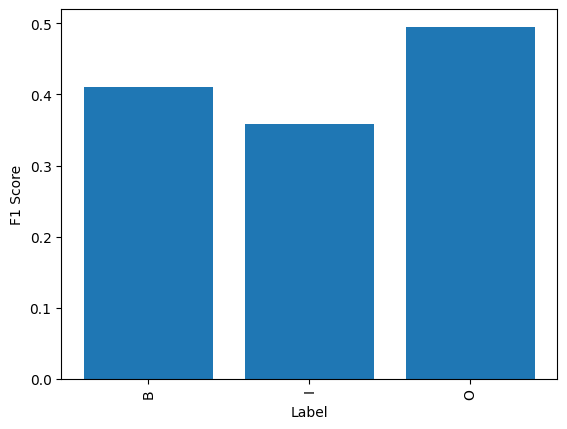

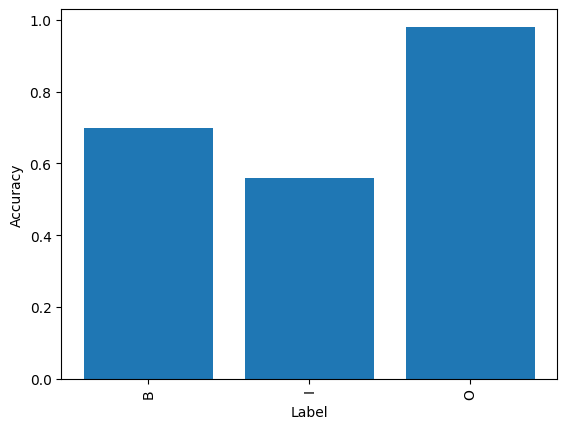

In [38]:
print('Bi-LSTM CRF with Word2Vec: Labelwise plots')
test_accuracy, test_f1 = test("t2_model4_word2vec.pt", word2vec, ate_test_data, device=device, show_labelwise=True, plot=True, print_labelwise=False)

print('Bi-LSTM CRF with GloVe: Labelwise plots')
test_accuracy, test_f1 = test("t2_model4_glove.pt", glove, ate_test_data, device=device, show_labelwise=True, plot=True, print_labelwise=False)

print('Bi-LSTM CRF with FastText: Labelwise plots')
test_accuracy, test_f1 = test("t2_model4_fasttext.pt", fasttext, ate_test_data, device=device, show_labelwise=True, plot=True, print_labelwise=False)